<a href="https://colab.research.google.com/github/hmalpr01/Finance/blob/main/Segmentaci%C3%B3n_y_Agrupaci%C3%B3n_de_Acciones_(Clustering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Segmentación y Agrupación de Acciones (Clustering)


##Importamos las librerias

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
pd.set_option("display.float_format", "{:.4f}".format)

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Descargando la info de acciones con API Yahoo Finance

Se seleccionaron las siguientes 10 acciones de ejemplo:

TSLA: Tesla, Inc.

WBD:Warner Bros. Discovery, Inc.

NFLX: Netflix, Inc.

INTC: Intel Corporation

NVDA:	NVIDIA Corporation

ORCL: Oracle Corporation

C: Citigroup Inc.

WMT: Walmart Inc.

MSFT: Microsoft Corporation

KO: The Coca-Cola Company

In [ ]:
# Parámetros iniciales
tickers = ["TSLA", "WBD", "NFLX","INTC", "NVDA", "ORCL","C","WMT","MSFT","KO"]
market_ticker = "SPY"
today_date = "2025-12-28"

In [ ]:
data = yf.download(tickers, end=today_date, period="2y",progress=False,auto_adjust=False)[["Adj Close","Volume"]]
spy_prices = yf.download(market_ticker, end=today_date, period="2y", progress=False,auto_adjust=False)["Adj Close"]

In [ ]:
col_precios =[]
col_ticker=[]
col_volumen =[]
for i in range(data.shape[1]):
    if data.columns[i][0]=='Adj Close':
        col_precios.append(data.columns[i])
        col_ticker.append(data.columns[i][1])
    if data.columns[i][0]=='Volume':
        col_volumen.append(data.columns[i])

In [ ]:
prices = data[col_precios]
prices.columns = col_ticker
volumen = data[col_volumen]
volumen.columns = col_ticker

## Análisis del precio de las acciones en el tiempo

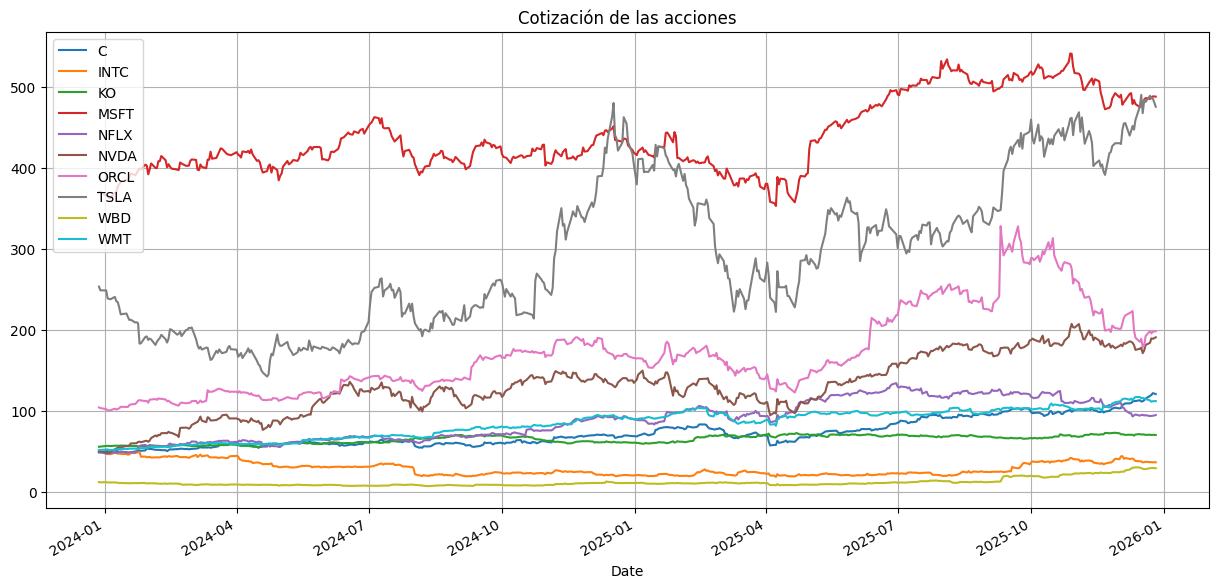

In [ ]:
prices.plot(figsize = (15, 7), title="Cotización de las acciones")
plt.grid()
plt.show()

### Análisis de los retornos individuales

In [ ]:
daily_returns = prices.pct_change().dropna(how="all")
spy_returns = spy_prices.pct_change().dropna()

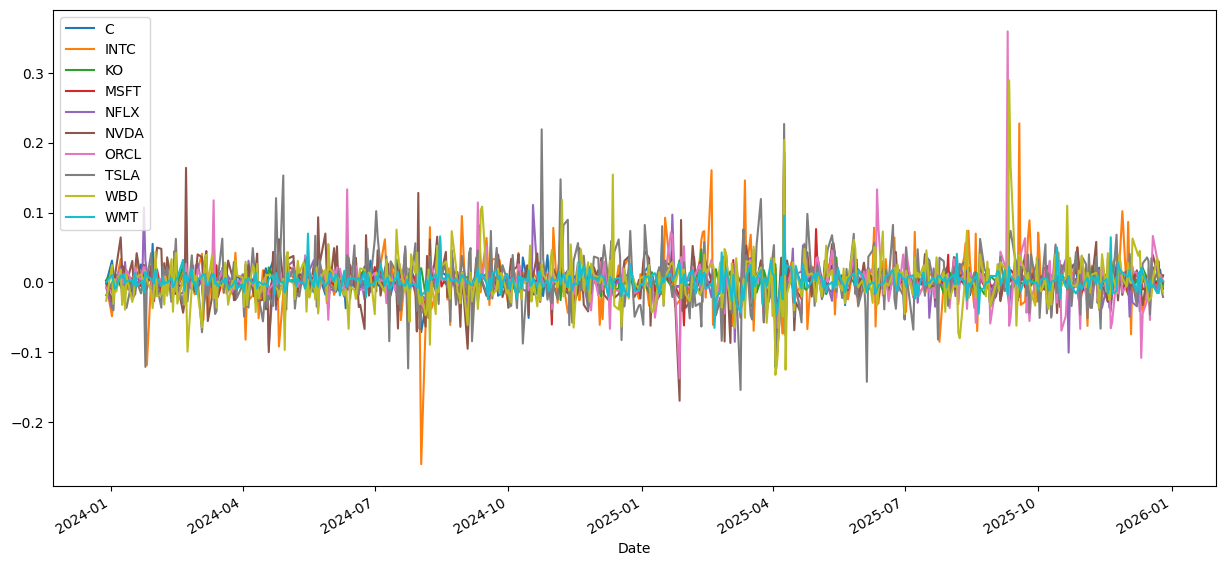

In [ ]:
daily_returns.plot(figsize = (15, 7))  #daily_returns[['AAPL']].plot()
plt.show()

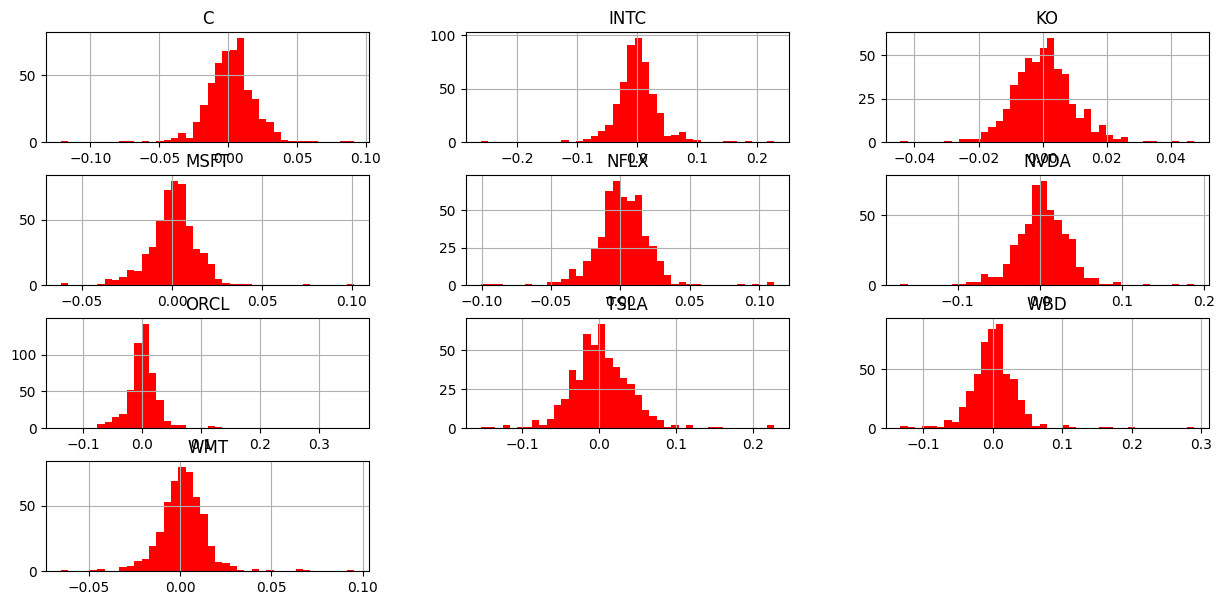

In [ ]:
daily_returns.hist(figsize=(15, 7), bins=40, color='red')
plt.show()

In [ ]:
daily_returns.describe()

## Análisis de Correlaciones

In [ ]:
# Alinear todo en un solo DataFrame (usa inner join para fechas comunes)
returns = pd.concat([daily_returns, spy_returns], axis=1).dropna(how="all").dropna()

In [ ]:
returns.head()

,C,INTC,KO,MSFT,NFLX,NVDA,ORCL,TSLA,WBD,WMT,SPY
Date,,,,,,,,,,,
2023-12-29,-0.0016,-0.0028,0.0031,0.0020,-0.0074,0.0000,-0.0077,-0.0186,-0.0265,0.0005,-0.0029
2024-01-02,0.0311,-0.0488,0.0151,-0.0137,-0.0378,-0.0273,-0.0130,-0.0002,0.0246,0.0104,-0.0056
2024-01-03,0.0113,-0.0157,0.0023,-0.0007,0.0038,-0.0124,-0.0154,-0.0401,-0.0309,0.0001,-0.0082
2024-01-04,0.0024,-0.0038,-0.0033,-0.0072,0.0094,0.0090,0.0013,-0.0022,0.0044,-0.0097,-0.0032
2024-01-05,0.0104,0.0004,-0.0015,-0.0005,-0.0013,0.0229,0.0014,-0.0018,-0.0132,-0.0067,0.0014


In [ ]:
mat_cor=returns.corr()

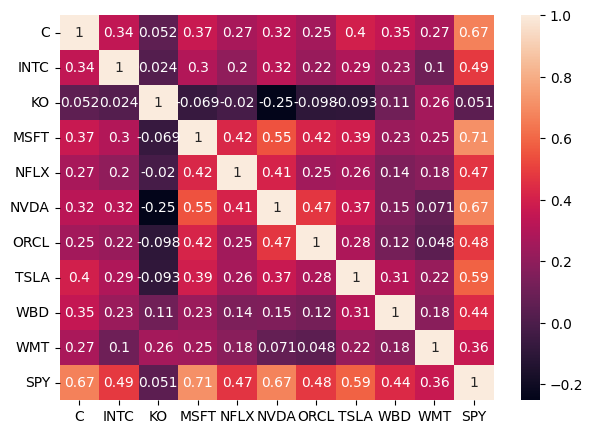

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(mat_cor, annot=True)
plt.show()

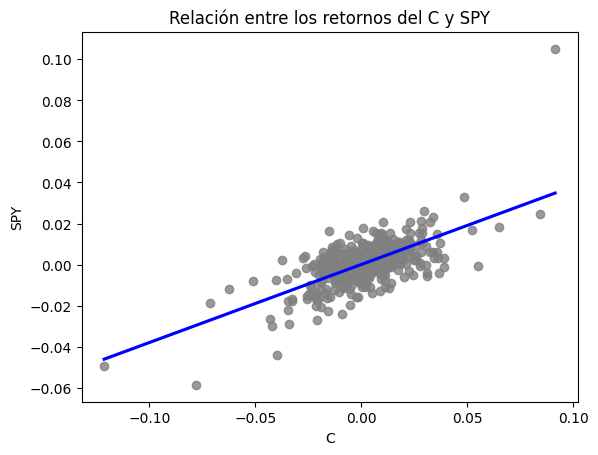

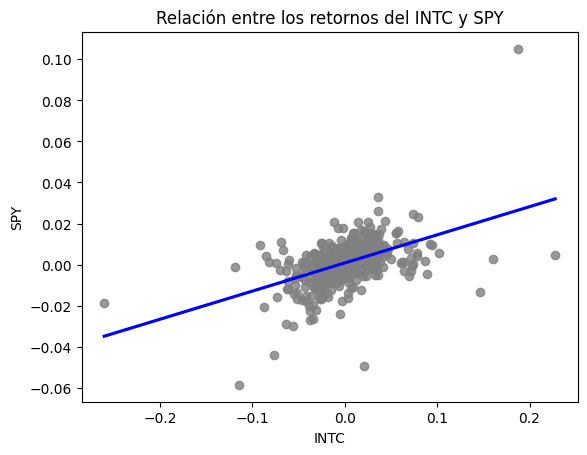

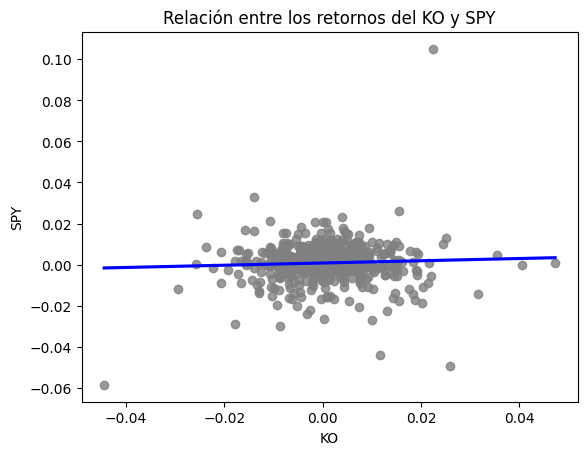

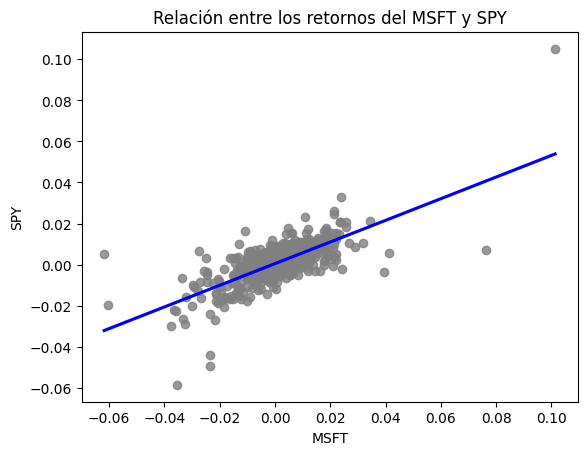

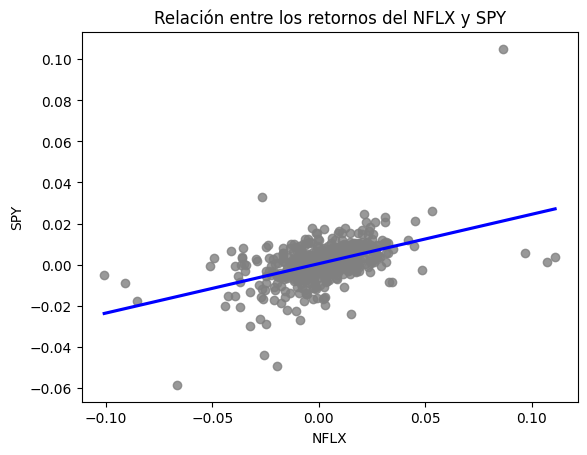

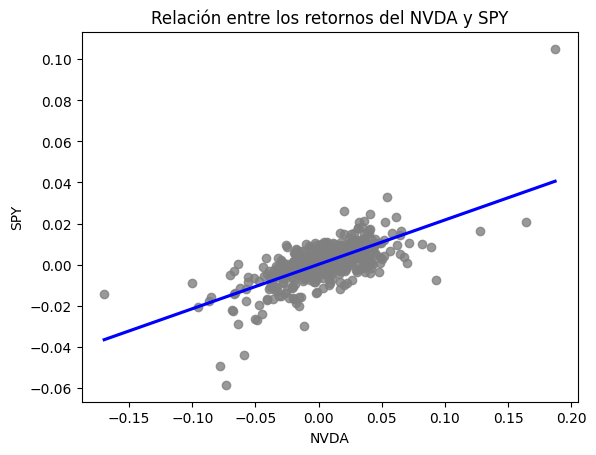

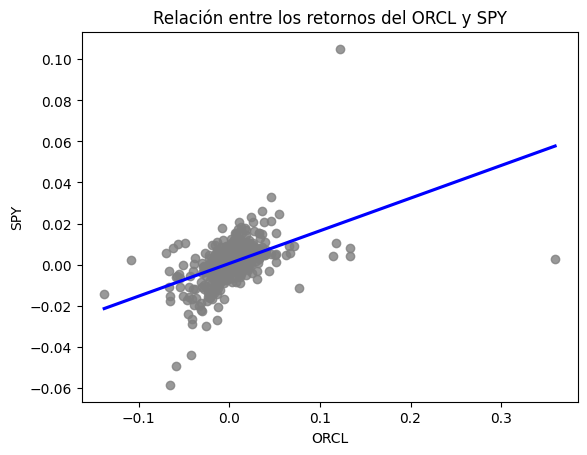

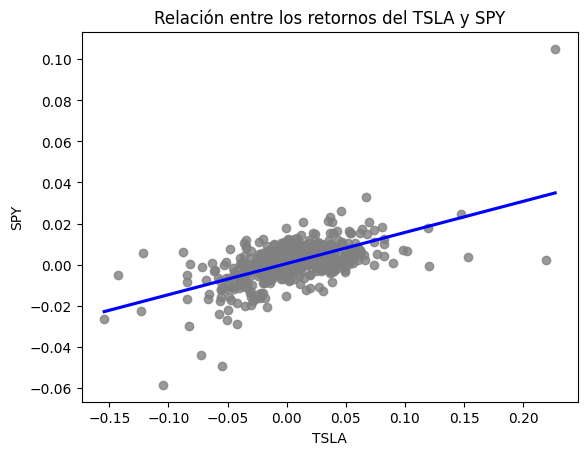

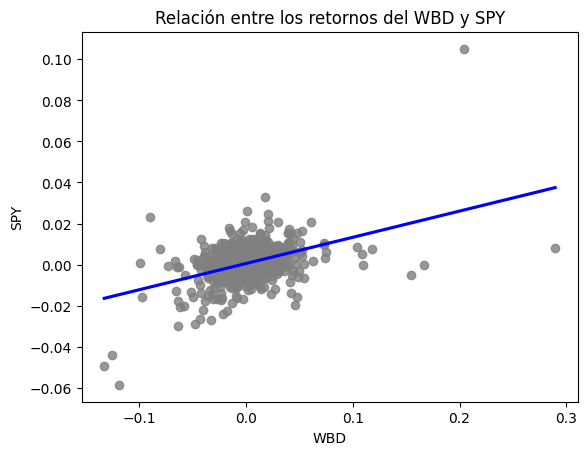

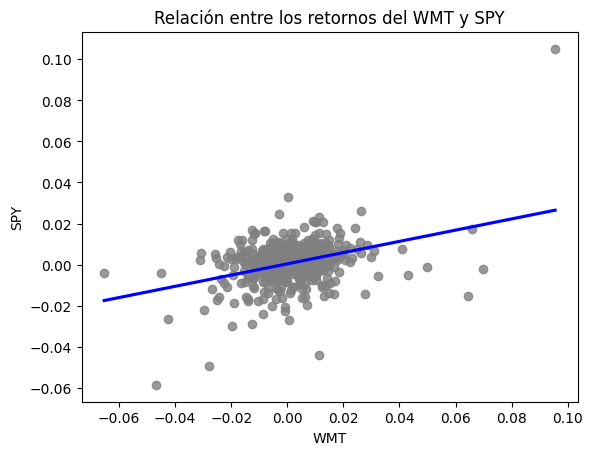

In [ ]:
for i in range(len(returns.columns)-1):
    plt.title("Relación entre los retornos del "+ returns.columns[i] + " y SPY")
    sns.regplot(x=returns.iloc[:,i],y=returns.iloc[:,-1],ci=False, color='grey',line_kws=dict(color="b"))
    plt.show()

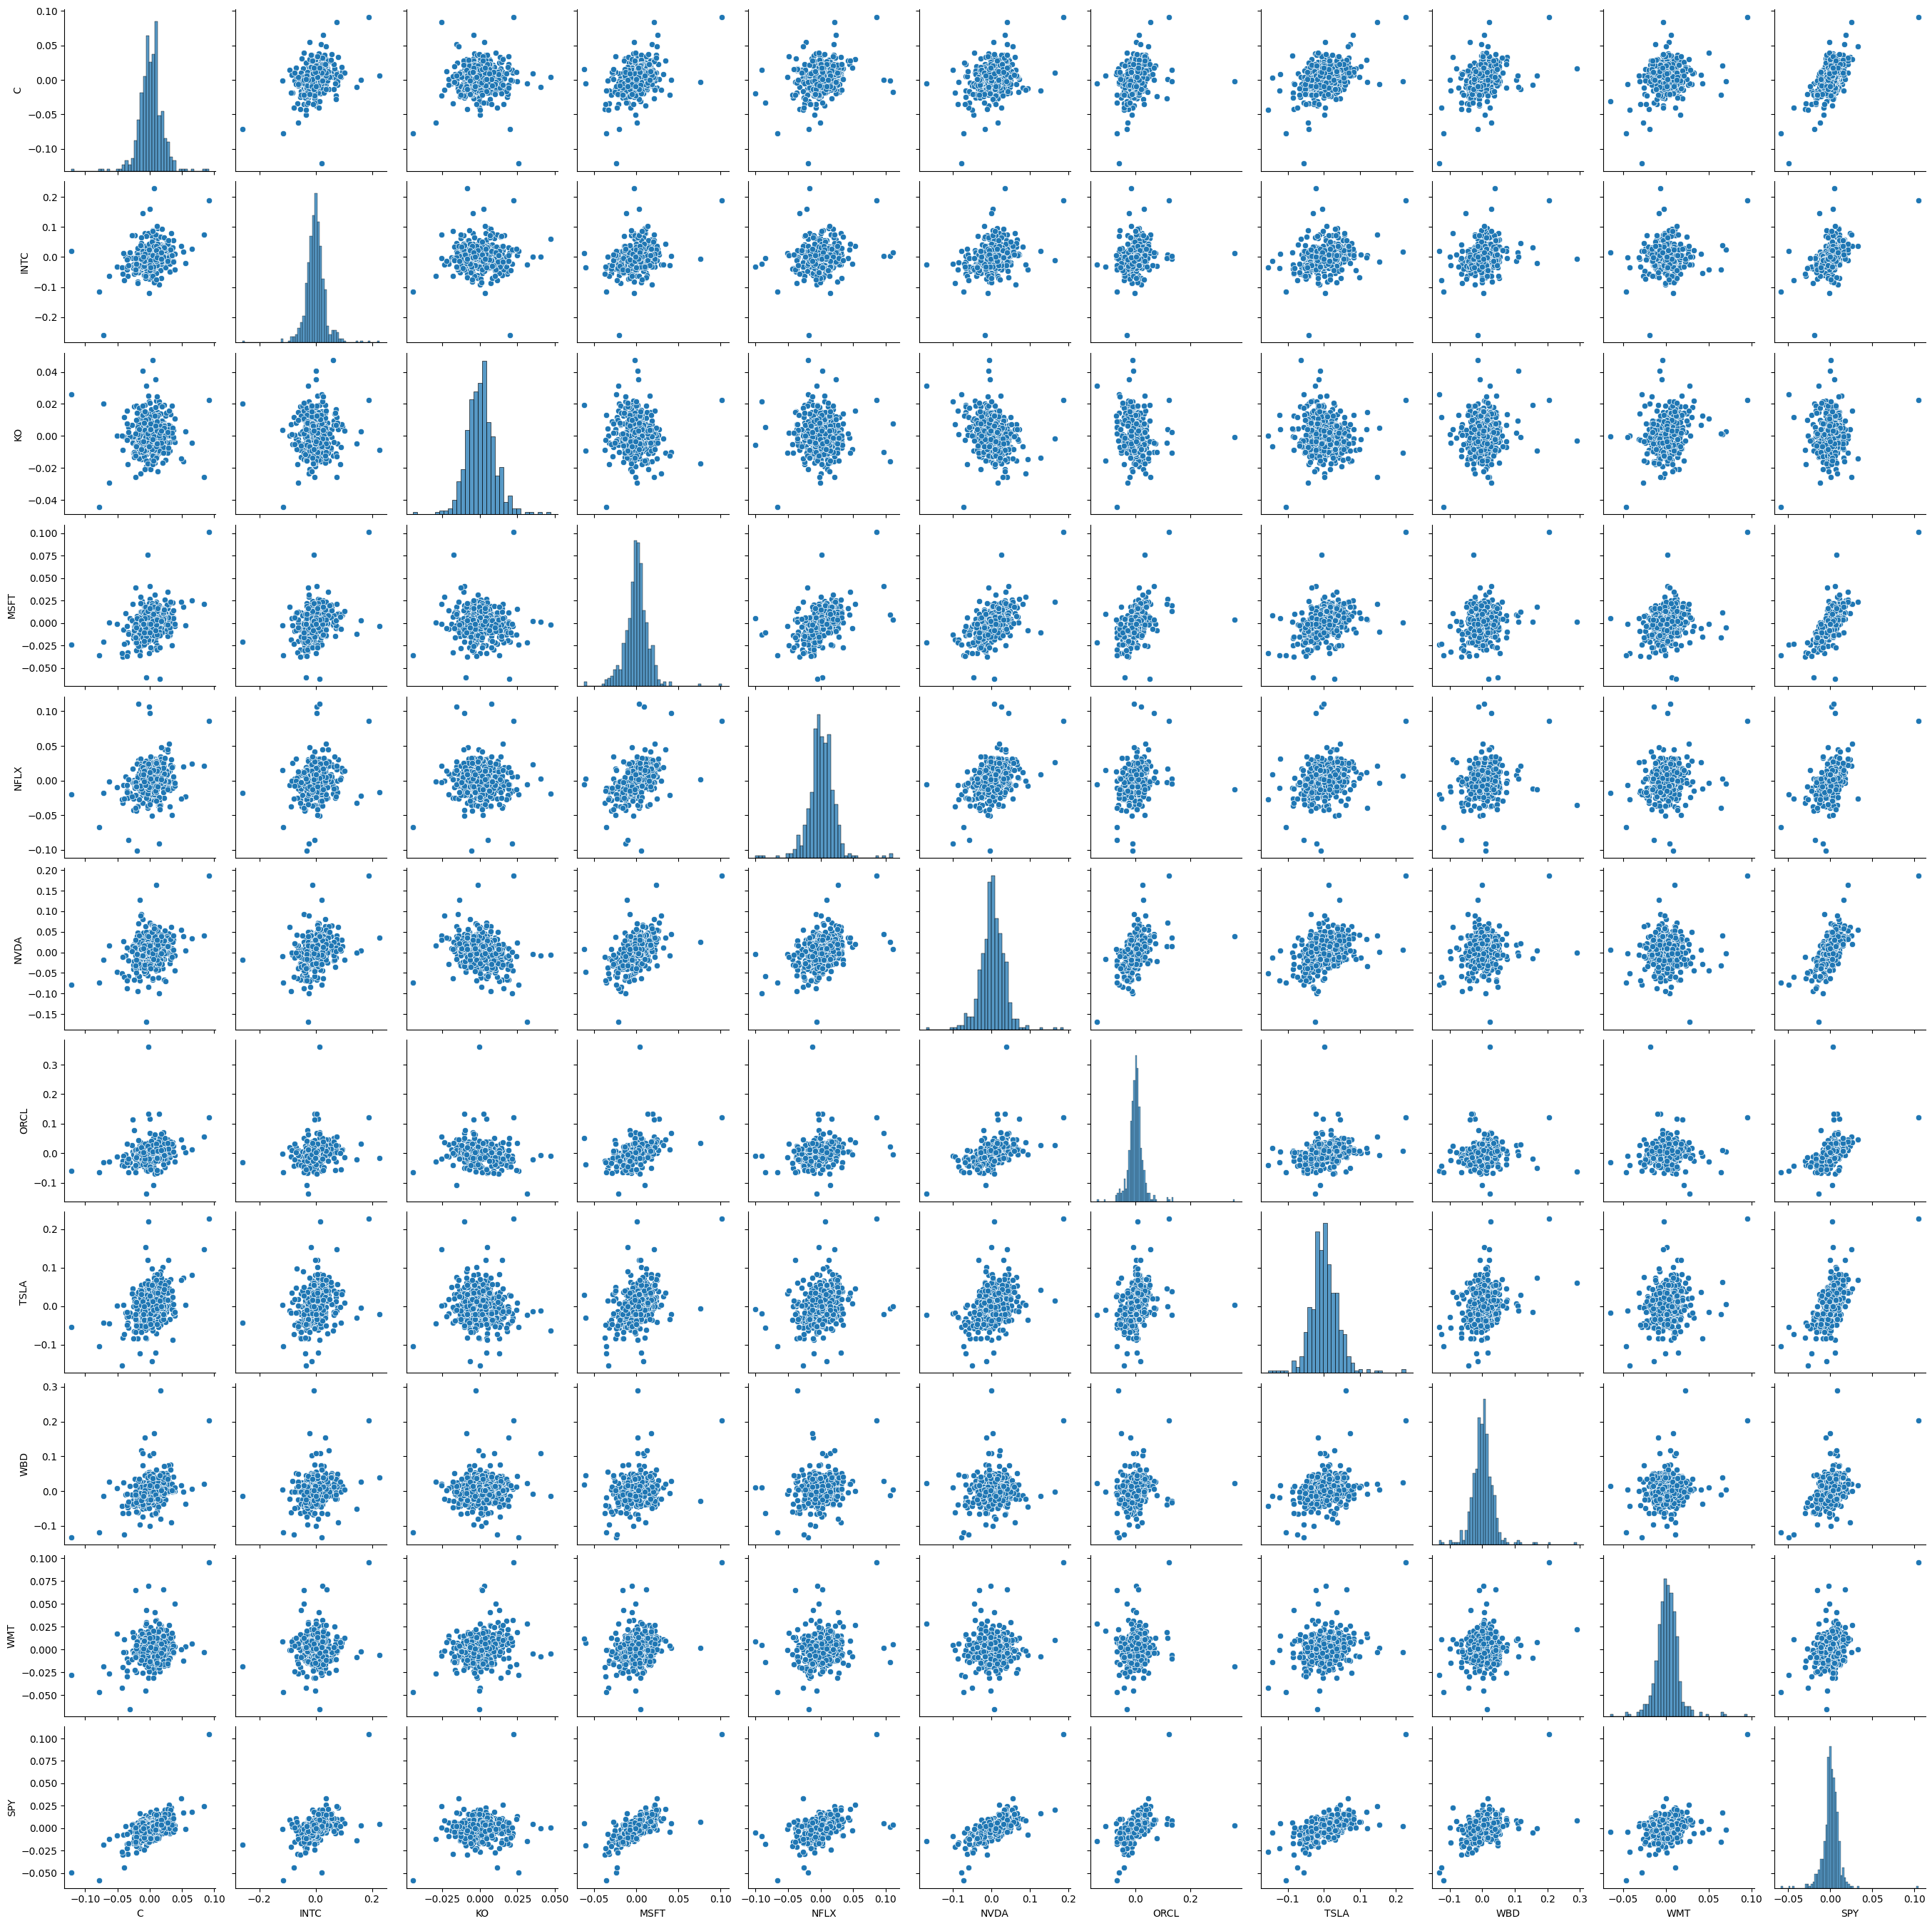

In [ ]:
sns.pairplot(returns)
plt.show()

##  Clustering

### Construimos nuestra matriz de features

In [ ]:
matriz_cov=returns.cov()

In [ ]:
matriz_corr=returns.corr()

In [ ]:
ret_1y = []
vol_1y=[]
beta = []
corr_market =[]
vol_30d=[]

for i in prices.columns:
    x_prices=prices.loc[prices.index.max(),i]/prices.loc[prices.index.min(),i]-1
    ret_1y.append(x_prices)

    x_std=returns.std(ddof=1)[i]* np.sqrt(252)
    vol_1y.append(x_std)

    cov = matriz_cov.loc[i,market_ticker]
    var = matriz_cov.loc[market_ticker,market_ticker]
    x_beta = cov/var
    beta.append(x_beta)

    x_cor=matriz_corr.loc[i,market_ticker]
    corr_market.append(x_cor)

    x_vol=volumen.tail(30)[i].mean()
    vol_30d.append(x_vol)


In [ ]:
dic1={'ret_1y':ret_1y,'vol_1y':vol_1y, 'beta':beta,'corr_with_market':corr_market,'vol_30d':vol_30d}
df_indicadores=pd.DataFrame(dic1)
df_indicadores.index=prices.columns
df_indicadores

,ret_1y,vol_1y,beta,corr_with_market,vol_30d
C,1.4916,0.2896,1.1854,0.6709,13400333.3333
INTC,-0.2720,0.5812,1.7222,0.4856,78758686.6667
KO,0.2618,0.1534,0.0477,0.0510,16842943.3333
MSFT,0.3190,0.2222,0.9686,0.7143,24904640.0000
NFLX,0.9260,0.3198,0.9164,0.4696,45284006.6667
NVDA,2.8495,0.5117,2.1066,0.6747,196429216.6667
ORCL,0.9050,0.4921,1.4343,0.4777,31667330.0000
TSLA,0.8769,0.6352,2.2772,0.5875,80765256.6667
WBD,1.4636,0.5584,1.4829,0.4352,60731673.3333
WMT,1.1735,0.2173,0.4808,0.3627,22844243.3333


In [ ]:
X=df_indicadores.copy()
scaler = StandardScaler()
X_std=scaler.fit_transform(X)
X_std=pd.DataFrame(X_std,columns=X.columns, index=X.index)

In [ ]:
X_std

,ret_1y,vol_1y,beta,corr_with_market,vol_30d
C,0.6074,-0.6502,-0.1167,0.9666,-0.8425
INTC,-1.5694,1.0973,0.6990,-0.0398,0.4158
KO,-0.9106,-1.4658,-1.8456,-2.3998,-0.7762
MSFT,-0.8400,-1.0536,-0.4462,1.2022,-0.6210
NFLX,-0.0908,-0.4692,-0.5255,-0.1264,-0.2287
NVDA,2.2835,0.6804,1.2831,0.9873,2.6811
ORCL,-0.1166,0.5631,0.2615,-0.0828,-0.4908
TSLA,-0.1513,1.4207,1.5424,0.5136,0.4544
WBD,0.5729,0.9606,0.3354,-0.3135,0.0687
WMT,0.2148,-1.0833,-1.1875,-0.7074,-0.6607


In [ ]:
wcss =[]
for i in range (1,6):
    kmeans = KMeans(n_clusters= i, n_init=10,random_state = 42)
    kmeans.fit(X_std)
    wcss.append(kmeans.inertia_)

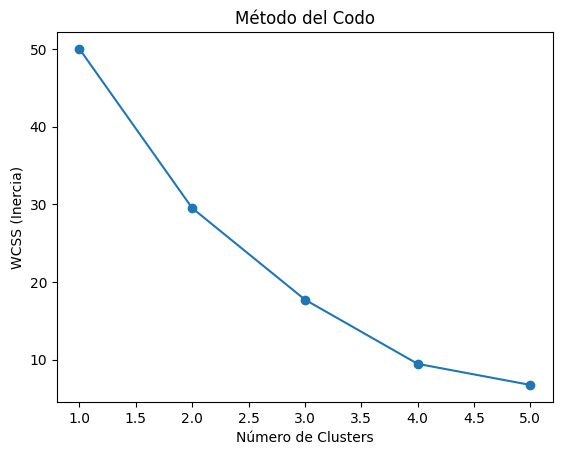

In [ ]:
# Graficamos el método de Elbow
plt.plot(range(1,6), wcss, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS (Inercia)')
plt.show()

Se eligen 4 clusters

In [ ]:
# 4. Entrenar modelo con X clusters
kmeans = KMeans(n_clusters=4, n_init=20, random_state=42)
clusters = kmeans.fit_predict(X_std)
df_indicadores['Cluster'] = clusters

In [ ]:
df_indicadores

,ret_1y,vol_1y,beta,corr_with_market,vol_30d,Cluster
C,1.4916,0.2896,1.1854,0.6709,13400333.3333,0
INTC,-0.2720,0.5812,1.7222,0.4856,78758686.6667,1
KO,0.2618,0.1534,0.0477,0.0510,16842943.3333,2
MSFT,0.3190,0.2222,0.9686,0.7143,24904640.0000,0
NFLX,0.9260,0.3198,0.9164,0.4696,45284006.6667,0
NVDA,2.8495,0.5117,2.1066,0.6747,196429216.6667,3
ORCL,0.9050,0.4921,1.4343,0.4777,31667330.0000,1
TSLA,0.8769,0.6352,2.2772,0.5875,80765256.6667,1
WBD,1.4636,0.5584,1.4829,0.4352,60731673.3333,1
WMT,1.1735,0.2173,0.4808,0.3627,22844243.3333,0


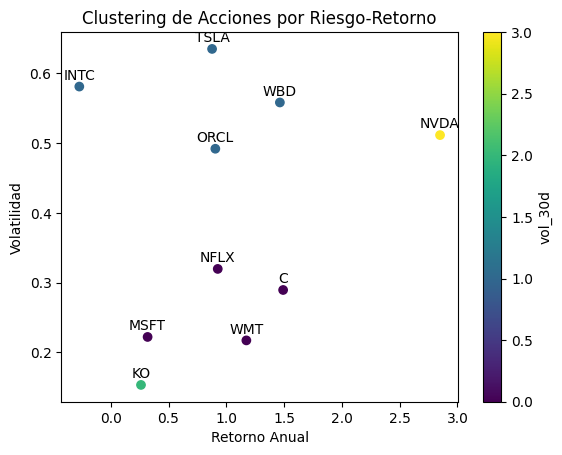

In [ ]:
scatter=plt.scatter(df_indicadores['ret_1y'],df_indicadores['vol_1y'],c=df_indicadores['Cluster'],cmap='viridis')
plt.colorbar(scatter, label='vol_30d')

for i, txt in enumerate(df_indicadores.index):
    plt.annotate(txt, (df_indicadores['ret_1y'][i], df_indicadores['vol_1y'][i]),textcoords="offset points", xytext=(0,5), ha='center')
plt.title('Clustering de Acciones por Riesgo-Retorno')
plt.xlabel('Retorno Anual')
plt.ylabel('Volatilidad')
plt.show()

### Descripción de los Clusteres

---
<b>“1er Cluster: Acciones de Crecimiento Moderado / Core Market”

Perfil cuantitativo
- Rendimiento: medio
- Volatilidad: media
- Beta: ≈ 1 (mercado)
- Correlación: alta
- Volumen: medio–alto

Interpretación
- Acciones que replican el comportamiento del mercado.
- Buen balance riesgo–retorno.
- Alta liquidez → atractivas para institucionales.
- Son el núcleo (core) de un portafolio diversificado.

Perfil típico
- Large caps
- Índices sectoriales
- Empresas líderes de su industria

In [ ]:
df_indicadores[df_indicadores['Cluster']==0]

,ret_1y,vol_1y,beta,corr_with_market,vol_30d,Cluster
C,1.4916,0.2896,1.1854,0.6709,13400333.3333,0
MSFT,0.3190,0.2222,0.9686,0.7143,24904640.0000,0
NFLX,0.9260,0.3198,0.9164,0.4696,45284006.6667,0
WMT,1.1735,0.2173,0.4808,0.3627,22844243.3333,0


In [ ]:
print("Rendimiento Prom: ",df_indicadores[df_indicadores['Cluster']==0]['ret_1y'].mean())
print("Volatilidad Prom: ",df_indicadores[df_indicadores['Cluster']==0]['vol_1y'].mean())
print("Beta Prom: ",df_indicadores[df_indicadores['Cluster']==0]['beta'].mean())
print("Corr Prom: ",df_indicadores[df_indicadores['Cluster']==0]['corr_with_market'].mean())
print("Vol Prom: ",df_indicadores[df_indicadores['Cluster']==0]['vol_30d'].mean())

Rendimiento Prom:  0.9775220098090471
Volatilidad Prom:  0.2622051751052948
Beta Prom:  0.8877906374744052
Corr Prom:  0.5543867298906489
Vol Prom:  26608305.833333332


---
<b>“2da: Acciones de Alto Crecimiento”

Perfil cuantitativo
- Rendimiento: muy alto
- Volatilidad: muy alta
- Beta: alta (≈ 1.9)
- Correlación: alta
- Volumen: muy alto

Interpretación
- Acciones altamente sensibles al mercado.
- Amplifican movimientos: Suben mucho en mercados alcistas/Caen fuerte en crisis
- Alta liquidez y fuerte componente especulativo.
- Ideales para estrategias tácticas o de corto plazo.

Perfil típico
- Tecnología
- Growth stocks
- Momentum stocks
- Acciones “hot” del mercado

In [ ]:
df_indicadores[df_indicadores['Cluster']==1]

,ret_1y,vol_1y,beta,corr_with_market,vol_30d,Cluster
INTC,-0.2720,0.5812,1.7222,0.4856,78758686.6667,1
ORCL,0.9050,0.4921,1.4343,0.4777,31667330.0000,1
TSLA,0.8769,0.6352,2.2772,0.5875,80765256.6667,1
WBD,1.4636,0.5584,1.4829,0.4352,60731673.3333,1


In [ ]:
print("Rendimiento Prom: ",df_indicadores[df_indicadores['Cluster']==1]['ret_1y'].mean())
print("Volatilidad Prom: ",df_indicadores[df_indicadores['Cluster']==1]['vol_1y'].mean())
print("Beta Prom: ",df_indicadores[df_indicadores['Cluster']==1]['beta'].mean())
print("Corr Prom: ",df_indicadores[df_indicadores['Cluster']==1]['corr_with_market'].mean())
print("Vol Prom: ",df_indicadores[df_indicadores['Cluster']==1]['vol_30d'].mean())

Rendimiento Prom:  0.7433830456944033
Volatilidad Prom:  0.5667483738170219
Beta Prom:  1.7291483228549442
Corr Prom:  0.49648719886294684
Vol Prom:  62980736.66666667


---
<b>“3er Cluster: Acciones Defensivas / Bajo Riesgo”

Perfil cuantitativo
- Rendimiento: bajo–moderado
- Volatilidad: baja
- Beta: muy baja (>0.36)
- Correlación: baja
- Volumen: bajo

Interpretación
- Acciones poco sensibles al mercado.
- Funcionan como amortiguadores de riesgo.
- Su desempeño no depende fuertemente de los ciclos de mercado.
- Menor interés especulativo (bajo volumen).

Perfil típico
- Utilities
- Consumo básico
- Empresas maduras y estables
- Acciones “hold” de largo plazo

In [ ]:
df_indicadores[df_indicadores['Cluster']==2]

,ret_1y,vol_1y,beta,corr_with_market,vol_30d,Cluster
KO,0.2618,0.1534,0.0477,0.0510,16842943.3333,2


In [ ]:
print("Rendimiento Prom: ",df_indicadores[df_indicadores['Cluster']==2]['ret_1y'].mean())
print("Volatilidad Prom: ",df_indicadores[df_indicadores['Cluster']==2]['vol_1y'].mean())
print("Beta Prom: ",df_indicadores[df_indicadores['Cluster']==2]['beta'].mean())
print("Corr Prom: ",df_indicadores[df_indicadores['Cluster']==2]['corr_with_market'].mean())
print("Vol Prom: ",df_indicadores[df_indicadores['Cluster']==2]['vol_30d'].mean())

Rendimiento Prom:  0.2617584250919882
Volatilidad Prom:  0.1534214164540969
Beta Prom:  0.04773239976388103
Corr Prom:  0.05098764884567829
Vol Prom:  16842943.333333332


<b> "4to Cluster: Acciones de Innovación Disruptiva"

Perfil cuantitativo

*   Rendimiento esperado: alto
*   Volatilidad: alta
*   Beta: elevada (≈ 2)
*   Correlación: media-alta con el sector tecnológico y el mercado general
*   Liquidez: muy alta (acción ampliamente transada)
*   Tendencia: crecimiento exponencial impulsado por innovación


Interpretación

*   Acción líder en tecnologías de frontera.
*   Riesgo elevado, pero con retorno potencial superior al promedio del mercado.
*   Su desempeño suele amplificarse en fases alcistas del sector tech.
*   Es un componente clave en portafolios de crecimiento y estrategias temáticas de IA.
*   Puede actuar como motor de retorno, pero también incrementar el riesgo total del portafolio.

Perfil típico

*   Mega/Large cap tecnológica
*   Dominancia en su industria (market share muy alto en hardware para IA)
*   Alta inversión en I+D
*   Fuerte adopción institucional y retail
*   Exposición a tendencias estructurales de largo plazo (demanda global de IA y centros de datos)

In [ ]:
df_indicadores[df_indicadores['Cluster']==3]

,ret_1y,vol_1y,beta,corr_with_market,vol_30d,Cluster
NVDA,2.8495,0.5117,2.1066,0.6747,196429216.6667,3


In [ ]:
print("Rendimiento Prom: ",df_indicadores[df_indicadores['Cluster']==3]['ret_1y'].mean())
print("Volatilidad Prom: ",df_indicadores[df_indicadores['Cluster']==3]['vol_1y'].mean())
print("Beta Prom: ",df_indicadores[df_indicadores['Cluster']==3]['beta'].mean())
print("Corr Prom: ",df_indicadores[df_indicadores['Cluster']==3]['corr_with_market'].mean())
print("Vol Prom: ",df_indicadores[df_indicadores['Cluster']==3]['vol_30d'].mean())

Rendimiento Prom:  2.8495243076373367
Volatilidad Prom:  0.5116603451198308
Beta Prom:  2.1065828483806124
Corr Prom:  0.6747369433250443
Vol Prom:  196429216.66666666
